# Day 1: Linear Regression for Finance
## Week 4: Machine Learning Foundations

---

**Learning Objectives:**
- Implement OLS regression from scratch
- Apply regression to factor models
- Interpret coefficients and statistics
- Understand assumptions and diagnostics

In [1]:
# Day 1 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM', 'XLF', 'XLK']].dropna()
returns = prices.pct_change().dropna() * 100

print("=" * 60)
print("LINEAR REGRESSION FOR FINANCE - DAY 1")
print("=" * 60)

LINEAR REGRESSION FOR FINANCE - DAY 1


## 1. OLS from Scratch

$$\hat{\beta} = (X^T X)^{-1} X^T y$$

In [2]:
# OLS from scratch
print("=" * 60)
print("OLS REGRESSION FROM SCRATCH")
print("=" * 60)

def ols_fit(X, y):
    """Fit OLS regression using the normal equation."""
    # Add intercept
    X_b = np.column_stack([np.ones(len(X)), X])
    
    # Normal equation: β = (X'X)^(-1) X'y
    beta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    
    return beta

def ols_predict(X, beta):
    """Make predictions."""
    X_b = np.column_stack([np.ones(len(X)), X])
    return X_b @ beta

def ols_statistics(X, y, beta):
    """Calculate regression statistics."""
    n = len(y)
    k = X.shape[1] if len(X.shape) > 1 else 1
    
    X_b = np.column_stack([np.ones(n), X])
    y_pred = X_b @ beta
    
    # Residuals
    residuals = y - y_pred
    
    # R-squared
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot
    
    # Adjusted R-squared
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    
    # Standard errors
    mse = ss_res / (n - k - 1)
    var_beta = mse * np.linalg.inv(X_b.T @ X_b)
    se = np.sqrt(np.diag(var_beta))
    
    # t-statistics
    t_stats = beta / se
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - k - 1))
    
    return {
        'r2': r2,
        'r2_adj': r2_adj,
        'se': se,
        't_stats': t_stats,
        'p_values': p_values,
        'residuals': residuals
    }

# Test: AAPL returns on SPY returns (CAPM)
X = returns['SPY'].values
y = returns['AAPL'].values

# Fit
beta = ols_fit(X, y)
stats_dict = ols_statistics(X, y, beta)

print(f"\nCAPM: AAPL = α + β × SPY")
print(f"-" * 40)
print(f"Alpha (α): {beta[0]:.4f} (daily excess return)")
print(f"Beta (β):  {beta[1]:.4f} (market sensitivity)")
print(f"\nR²:        {stats_dict['r2']:.4f}")
print(f"Adj R²:    {stats_dict['r2_adj']:.4f}")
print(f"\nt-statistics:")
print(f"  α: {stats_dict['t_stats'][0]:.2f} (p={stats_dict['p_values'][0]:.4f})")
print(f"  β: {stats_dict['t_stats'][1]:.2f} (p={stats_dict['p_values'][1]:.6f})")

OLS REGRESSION FROM SCRATCH

CAPM: AAPL = α + β × SPY
----------------------------------------
Alpha (α): 0.0405 (daily excess return)
Beta (β):  1.2212 (market sensitivity)

R²:        0.6037
Adj R²:    0.6035

t-statistics:
  α: 1.38 (p=0.1669)
  β: 51.90 (p=0.000000)


In [3]:
# Verify with sklearn and statsmodels
print("=" * 60)
print("VERIFICATION WITH LIBRARIES")
print("=" * 60)

# sklearn
lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)

print(f"\nsklearn:")
print(f"  α: {lr.intercept_:.4f}")
print(f"  β: {lr.coef_[0]:.4f}")

# statsmodels
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

print(f"\nstatsmodels:")
print(f"  α: {model.params[0]:.4f}")
print(f"  β: {model.params[1]:.4f}")

print(f"\nOur implementation:")
print(f"  α: {beta[0]:.4f}")
print(f"  β: {beta[1]:.4f}")

print("\n✅ All match!")

VERIFICATION WITH LIBRARIES

sklearn:
  α: 0.0405
  β: 1.2212

statsmodels:
  α: 0.0405
  β: 1.2212

Our implementation:
  α: 0.0405
  β: 1.2212

✅ All match!


## 2. CAPM Beta Estimation

CAPM BETA FOR MULTIPLE STOCKS

Stock    Alpha     Beta       R²  t-stat (β)       p-value
 AAPL 0.040484 1.221240 0.603740   51.901022  0.000000e+00
 MSFT 0.023202 1.152589 0.644252   56.584536  0.000000e+00
  JPM 0.017410 1.072739 0.501338   42.160275 1.942946e-269


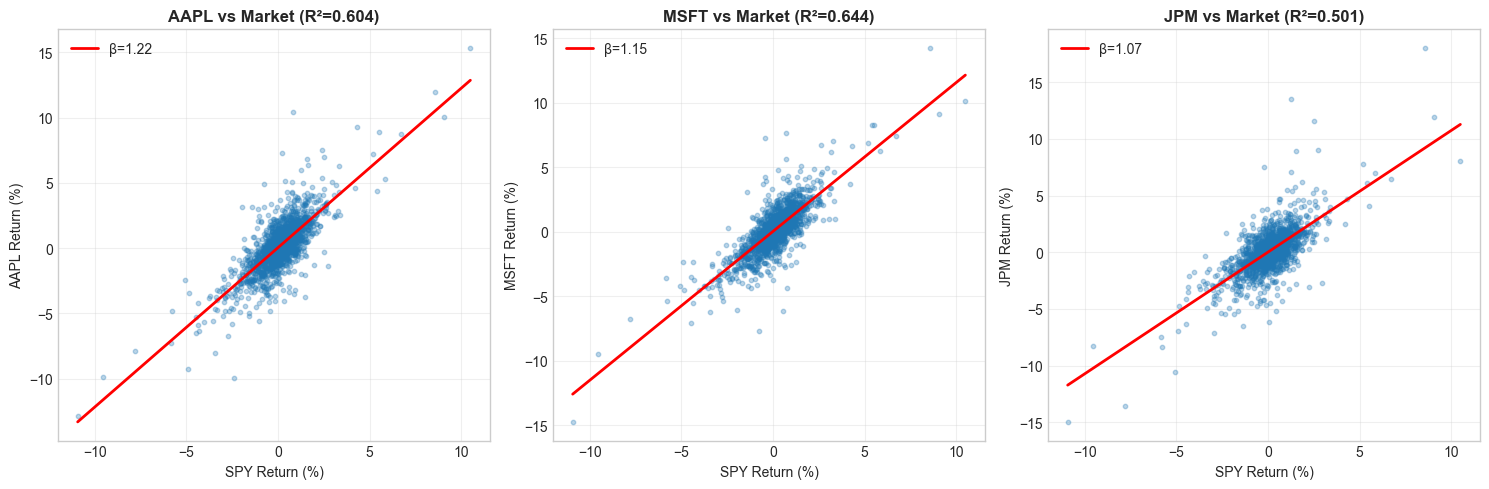

In [4]:
# Calculate beta for multiple stocks
print("=" * 60)
print("CAPM BETA FOR MULTIPLE STOCKS")
print("=" * 60)

market = returns['SPY']
stocks = ['AAPL', 'MSFT', 'JPM']

beta_results = []
for stock in stocks:
    X_sm = sm.add_constant(market)
    model = sm.OLS(returns[stock], X_sm).fit()
    
    beta_results.append({
        'Stock': stock,
        'Alpha': model.params[0],
        'Beta': model.params[1],
        'R²': model.rsquared,
        't-stat (β)': model.tvalues[1],
        'p-value': model.pvalues[1]
    })

beta_df = pd.DataFrame(beta_results)
print("\n" + beta_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, stock in zip(axes, stocks):
    ax.scatter(market, returns[stock], alpha=0.3, s=10)
    
    # Regression line
    X_sm = sm.add_constant(market)
    model = sm.OLS(returns[stock], X_sm).fit()
    x_line = np.linspace(market.min(), market.max(), 100)
    y_line = model.params[0] + model.params[1] * x_line
    ax.plot(x_line, y_line, 'r-', lw=2, label=f'β={model.params[1]:.2f}')
    
    ax.set_xlabel('SPY Return (%)')
    ax.set_ylabel(f'{stock} Return (%)')
    ax.set_title(f'{stock} vs Market (R²={model.rsquared:.3f})', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Multi-Factor Regression

In [5]:
# Multi-factor model
print("=" * 60)
print("MULTI-FACTOR REGRESSION")
print("=" * 60)

# Use sector ETFs as factors
y = returns['AAPL']
X = returns[['SPY', 'XLK']].copy()  # Market + Tech sector

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

print(model.summary())

MULTI-FACTOR REGRESSION
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1875.
Date:                Tue, 20 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:45:26   Log-Likelihood:                -2688.2
No. Observations:                1770   AIC:                             5382.
Df Residuals:                    1767   BIC:                             5399.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0268      0

## 4. Regression Diagnostics

REGRESSION DIAGNOSTICS


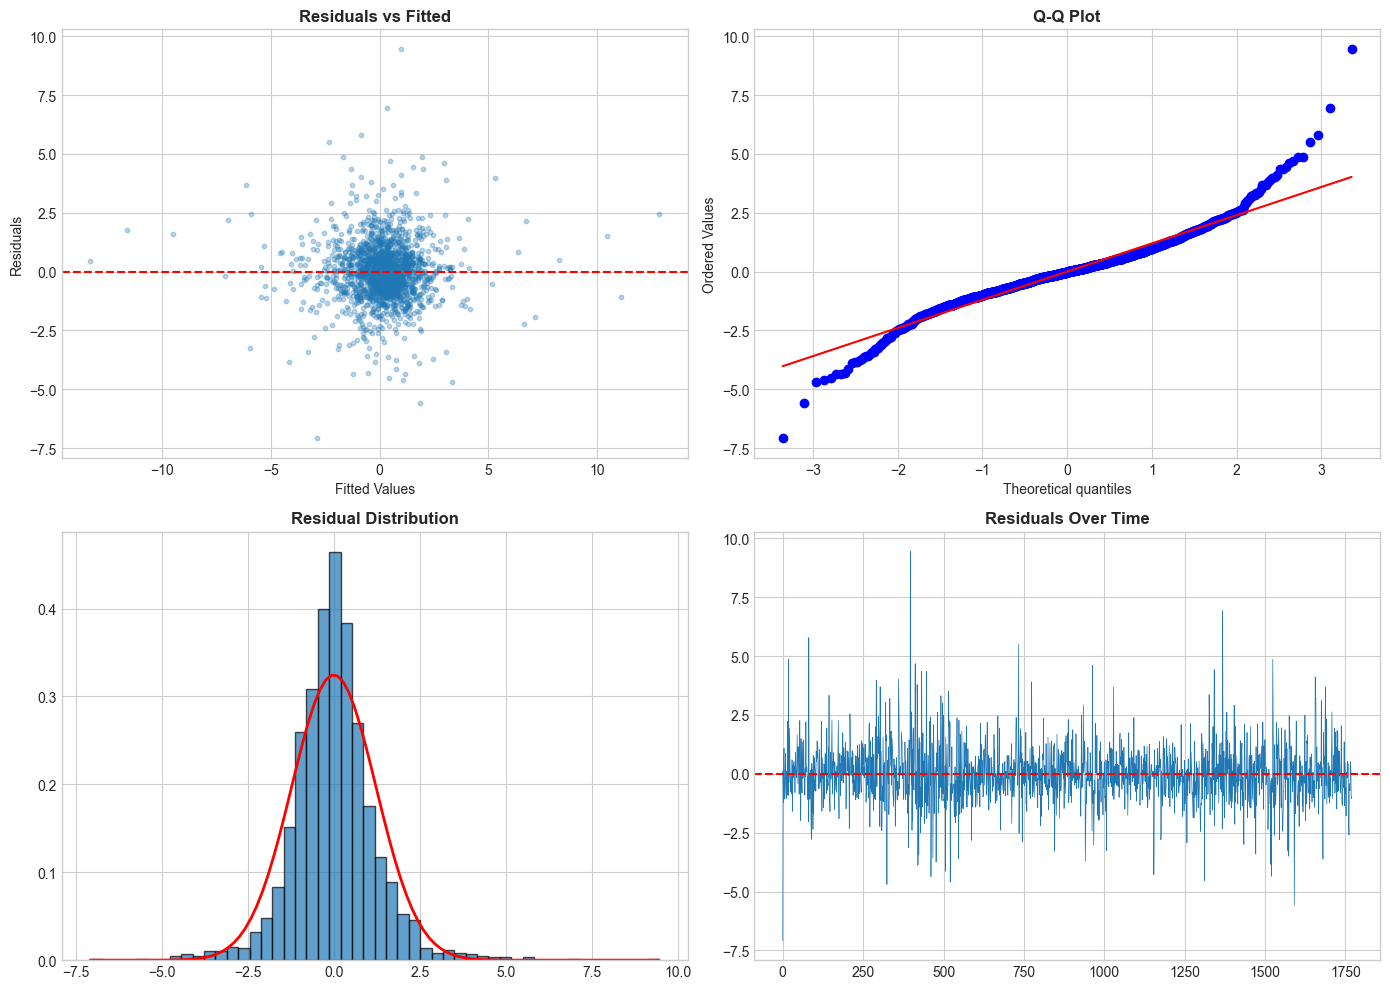


Diagnostic Tests:
  Durbin-Watson (autocorrelation): 1.820
    (Close to 2 = no autocorrelation)

  Jarque-Bera (normality): stat=1927.60, p=0.0000
    (p < 0.05 → non-normal residuals)


In [6]:
# Regression diagnostics
print("=" * 60)
print("REGRESSION DIAGNOSTICS")
print("=" * 60)

# Simple CAPM model
X = sm.add_constant(market)
model = sm.OLS(returns['AAPL'], X).fit()
residuals = model.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0,0].scatter(model.fittedvalues, residuals, alpha=0.3, s=10)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted', fontweight='bold')

# 2. Q-Q plot
stats.probplot(residuals, dist='norm', plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot', fontweight='bold')

# 3. Residual histogram
axes[1,0].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1,0].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', lw=2)
axes[1,0].set_title('Residual Distribution', fontweight='bold')

# 4. Residuals over time
axes[1,1].plot(residuals.values, lw=0.5)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title('Residuals Over Time', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical tests
from scipy.stats import jarque_bera, shapiro
from statsmodels.stats.stattools import durbin_watson

print("\nDiagnostic Tests:")
print(f"  Durbin-Watson (autocorrelation): {durbin_watson(residuals):.3f}")
print(f"    (Close to 2 = no autocorrelation)")

jb_stat, jb_p = jarque_bera(residuals)
print(f"\n  Jarque-Bera (normality): stat={jb_stat:.2f}, p={jb_p:.4f}")
print(f"    (p < 0.05 → non-normal residuals)")

## 📝 Key Takeaways - Day 1

### OLS Formula:
$$\hat{\beta} = (X^T X)^{-1} X^T y$$

### CAPM Model:
$$R_i - R_f = \alpha + \beta (R_m - R_f) + \epsilon$$

- β > 1: More volatile than market
- β < 1: Less volatile than market
- α > 0: Excess return (skill or risk?)

### Key Statistics:
| Metric | Interpretation |
|--------|---------------|
| R² | Variance explained |
| t-stat | Significance (>2 typically) |
| p-value | < 0.05 = significant |
| DW | ~2 = no autocorrelation |

### Interview Questions:
- "Derive the OLS estimator"
- "What does beta measure?"
- "What are OLS assumptions?"